# Seaborn ile Doğrusal Regresyon

🚀 Seaborn kullanarak Doğrusal Regresyon analizine görsel olarak başlayalım!

Hedefimiz aşağıdakilerin ilk anlayışını elde etmektir:
- `orders` özelikleri ve
- onlarla ilişkili `review_scores`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import Modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

⚠️ Devam etmeden önce:
* 💾 Önceki ünitenin Orders challenge'ının çözümünü indirin
* 👥 `order_solution.py` dosyasının içeriğini `olist/order.py` dosyanıza kopyala-yapıştır yapın

⚠️ `olist` deponuzda `order.py` dosyasındaki kod değişikliklerini commit etmeyi unutmayın!

👇 Öncelikle `orders` veri setini içeri aktarın

In [3]:
from olist.order import Order

orders = Order().get_training_data(with_distance_seller_customer=False)
orders.head()

,delay_vs_expected,dim_is_five_star,dim_is_one_star,expected_wait_time,freight_value,number_of_items,number_of_sellers,order_id,order_status,price,review_score,wait_time
0,0.0,0,0,15.544063,8.72,1,1,e481f51cbdc54678b7cc49136f2d6af7,delivered,29.99,4,8.436574
1,0.0,0,0,19.137766,22.76,1,1,53cdb2fc8bc7dce0b6741e2150273451,delivered,118.70,4,13.782037
2,0.0,1,0,26.639711,19.22,1,1,47770eb9100c2d0c44946d9cf07ec65d,delivered,159.90,5,9.394213
3,0.0,1,0,26.188819,27.20,1,1,949d5b44dbf5de918fe9c16f97b45f8a,delivered,45.00,5,13.208750
4,0.0,1,0,12.112049,8.72,1,1,ad21c59c0840e6cb83a9ceb5573f8159,delivered,19.90,5,2.873877


## 1 - Özellik Korelasyonunu İnceleme

❓Özellikler arasındaki çeşitli korelasyonları inceleyin: hangi özellik `review_score` ile en çok korelasyonlu görünüyor?

<details>
    <summary>▸ İpucu</summary>

* `DataFrame.corr(numeric_only=True)` kullanın `sns.heatmap()` ve `cmap='coolwarm'` ile kombinasyon yaparak
* `review_score` ile her bir özellik arasındaki korelasyon katsayılarının mutlak değerlerine bakın,
    * katsayı ne kadar yüksekse, verilen özellik `review_score` ile o kadar çok korelasyonludur (pozitif veya negatif)

</details>

> Not: Korelasyonlar mutlak değere göre sıralanmıştır; işaret (pozitif/negatif) ilişkinin yönünü göstermektedir.

In [4]:
# Sayısal değişkenler arası korelasyon matrisi
corr = orders.corr(numeric_only=True)

# review_score ile olan korelasyonların MUTLAK değerleri
review_corr_abs = corr["review_score"].abs().sort_values(ascending=False)

# review_score'un kendisi ve ondan türetilmiş flag'leri çıkarıyoruz
top_related = review_corr_abs.drop(
    labels=["review_score", "dim_is_one_star", "dim_is_five_star"],
    errors="ignore"
)

top_related.head(10)

wait_time             0.333758
delay_vs_expected     0.272281
number_of_items       0.123492
number_of_sellers     0.116942
freight_value         0.090013
expected_wait_time    0.052410
price                 0.034742
Name: review_score, dtype: float64

### review_score ile En İlişkili Değişkenler

Aşağıdaki tablo, `review_score` ile diğer sayısal değişkenler arasındaki korelasyonların **mutlak değerlerine** göre sıralanmış halini göstermektedir.

- En güçlü ilişki **wait_time** (|r| ≈ 0.33) ile gözlemlenmektedir.
- Bunu **delay_vs_expected** (|r| ≈ 0.27) takip etmektedir.
- Ürün sayısı (`number_of_items`) ve satıcı sayısı (`number_of_sellers`) gibi sipariş karmaşıklığına dair değişkenler daha zayıf ama yine de negatif ilişkiler göstermektedir.
- Fiyat (`price`) ve kargo bedeli (`freight_value`) gibi parasal değişkenlerin `review_score` ile ilişkisi oldukça düşüktür.

Bu sonuçlar, müşteri memnuniyetinin en çok **teslimat süresi** ve özellikle **gecikme** ile ilişkili olduğunu; siparişin parasal büyüklüğünden ziyade **zamanında teslimatın** daha belirleyici bir faktör olduğunu göstermektedir.

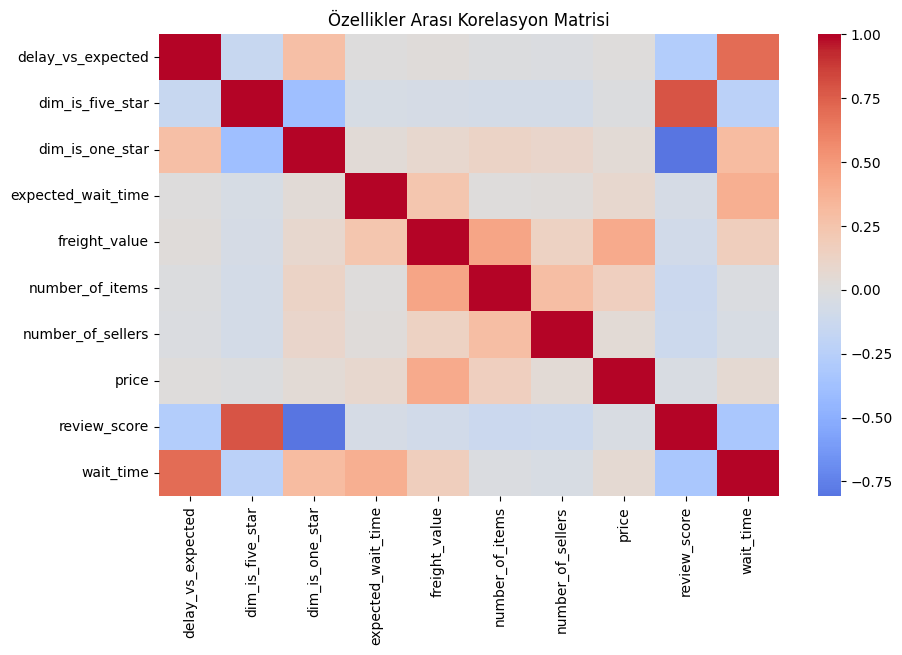

In [5]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0
)
plt.title("Özellikler Arası Korelasyon Matrisi")
plt.show()

### Özellikler Arası Korelasyonların Yorumlanması

Isı haritası, sipariş özellikleri arasındaki doğrusal ilişkilerin yönünü ve gücünü görselleştirmektedir.

- `review_score`, en güçlü pozitif korelasyonu **dim_is_five_star** ile, en güçlü negatif korelasyonu ise **dim_is_one_star** ile göstermektedir.  
  Bu beklenen bir durumdur; çünkü bu değişkenler doğrudan `review_score`’dan türetilmiştir.

- Türetilmiş bu değişkenler dışarıda bırakıldığında, `review_score` ile en güçlü ilişkili değişkenlerin:
  - **wait_time** (negatif),
  - **delay_vs_expected** (negatif)
  olduğu açıkça görülmektedir.

- `wait_time` ile `delay_vs_expected` arasında güçlü pozitif korelasyon bulunmaktadır; bu da teslimat süresi uzadıkça gecikme ihtimalinin arttığını göstermektedir.

- `number_of_items`, `number_of_sellers`, `price` ve `freight_value` gibi değişkenlerin `review_score` ile korelasyonları görece zayıftır.
  Bu durum, müşteri memnuniyetinin siparişin parasal büyüklüğünden veya karmaşıklığından ziyade **teslimat performansına** daha duyarlı olduğunu düşündürmektedir.

Genel olarak korelasyon matrisi, müşteri değerlendirme puanlarının en çok **teslimat süresi ve gecikme** ile ilişkili olduğunu göstermekte ve bir sonraki adımda bu ilişkilerin doğrusal regresyon ile daha detaylı incelenmesini motive etmektedir.

* 😏 _Kaptan Açık :_
    * `review_score` kendisiyle %100 korelasyonludur
    * ve `dim_is_one_star` ve `dim_is_five_star` ile güçlü korelasyonludur...
* ⚠️ `review_score` ile ilgili sonraki iki en yüksek korelasyon katsayısı :
    * `wait_time` : - %34
    * `delay_vs_expected` : - %27

## 2. `review_score` ile teslimat süresi arasında Doğrusal Regresyon

👉 Görünüşe göre `review_score` çoğunlukla `wait_time` (= - %34) ve `delay_vs_expected` (- %27) ile korelasyonludur.

🎨 Bu korelasyonları `seaborn` ile araştıralım

### 2.1 Grafikler
❓ Sırasıyla `review_score` ile `wait_time` ve `delay_vs_expected` arasında regresyon yapan 2 grafik oluşturun.

<u>İpuçları</u>:

- Hız açısından veri çerçevesini rastgele bir `10.000 satırlık örneğe` indirin (veri keşiflemede iyi bir uygulama)
- Gerekirse her yürütmede örneği değiştirilmekten kaçınmak için `DataFrame.sample()` sabit bir `random_state` ile kullanın
- Regresyon `lines` çizmek için `sns.regplot()` kullanın
- Saçılım grafiğinin yoğunluğunu daha iyi görselleştirmek için bazı `y_jitter` parametreleri ekleyin
- `sns.regplot()` hemen sonrasına bunu ekleyerek `xlim` ve `ylim` sınırlayın (aynı hücrede):
  ```python
  plt.xlim(right=70)
  plt.ylim(bottom=0)
  ```

In [6]:
# Hız için 10.000 satırlık sabit örnek alıyorum
sample_orders = orders.sample(n=10_000, random_state=42)

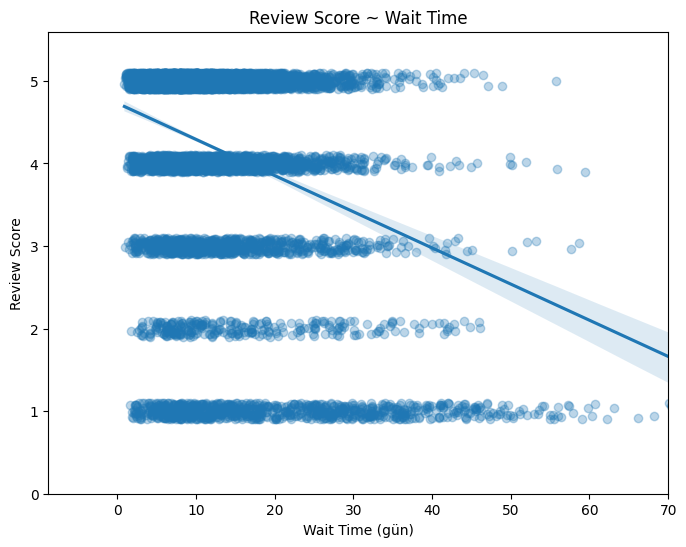

In [7]:
plt.figure(figsize=(8, 6))

sns.regplot(
    data=sample_orders,
    x="wait_time",
    y="review_score",
    y_jitter=0.1,
    scatter_kws={"alpha": 0.3}
)

plt.xlim(right=70)
plt.ylim(bottom=0)
plt.title("Review Score ~ Wait Time")
plt.xlabel("Wait Time (gün)")
plt.ylabel("Review Score")
plt.show()

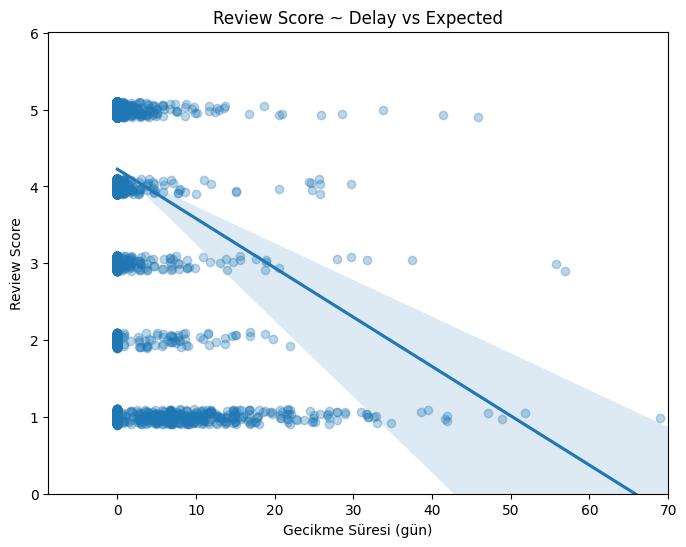

In [8]:
plt.figure(figsize=(8, 6))

sns.regplot(
    data=sample_orders,
    x="delay_vs_expected",
    y="review_score",
    y_jitter=0.1,
    scatter_kws={"alpha": 0.3}
)

plt.xlim(right=70)
plt.ylim(bottom=0)
plt.title("Review Score ~ Delay vs Expected")
plt.xlabel("Gecikme Süresi (gün)")
plt.ylabel("Review Score")
plt.show()

### Review Score ~ Wait Time Doğrusal Regresyonu

Bu grafik, siparişin teslim edilmesi için geçen süre (`wait_time`) ile müşteri değerlendirme puanı (`review_score`) arasındaki ilişkiyi göstermektedir.

- Regresyon çizgisinin **negatif eğimli** olması, teslimat süresi uzadıkça ortalama review skorunun düştüğünü göstermektedir.
- Görsel olarak eğim yaklaşık **-0.05** civarındadır.

Bu şu anlama gelir:

> Bir siparişin teslim edilmesi için geçen süre her **1 gün arttığında**, müşteri değerlendirme puanı **ortalama olarak yaklaşık 0.05 puan düşmektedir**.

- Noktaların yatay bantlar halinde görünmesi beklenen bir durumdur; çünkü `review_score` yalnızca **1 ile 5 arasında ayrık (kategorik) değerler** alabilmektedir.
- Buna rağmen, regresyon çizgisi net bir aşağı yönlü trend sergilemekte ve teslimat süresinin müşteri memnuniyeti üzerinde **olumsuz bir ilişkiye sahip olduğunu** göstermektedir.

- Regresyon çizgisi etrafındaki **%95 güven aralığı**, özellikle uzun teslimat sürelerinde genişlemektedir.
  Bu durum, yüksek `wait_time` değerlerinde gözlem sayısının azalması nedeniyle belirsizliğin arttığını göstermektedir.

Sonuç olarak, teslimat süresi müşteri değerlendirme puanı ile **anlamlı ve negatif yönlü bir ilişkiye sahiptir**; teslimat geciktikçe müşteri memnuniyeti düşme eğilimindedir.

### Review Score ~ Delay vs Expected Doğrusal Regresyonu

Bu grafik, siparişin **beklenen teslim tarihine göre ne kadar geciktiği**
(`delay_vs_expected`) ile müşteri değerlendirme puanı (`review_score`) arasındaki ilişkiyi göstermektedir.

- Regresyon çizgisinin **belirgin ve daha dik negatif eğimli** olması,
  gecikmenin müşteri memnuniyeti üzerinde güçlü bir olumsuz etkiye sahip olduğunu göstermektedir.
- Görsel olarak eğim yaklaşık **-0.1** civarındadır.

Bu şu anlama gelir:

> Bir sipariş, beklenen teslim tarihinden **her 1 gün geç teslim edildiğinde**,
> müşteri değerlendirme puanı **ortalama olarak yaklaşık 0.1 puan düşmektedir**.

- Bu etki, yalnızca toplam bekleme süresine kıyasla (**wait_time**),
  müşteri memnuniyetini **daha güçlü biçimde etkilemektedir**.
- Çünkü müşteriler genellikle teslimat süresinin uzun olmasını tolere edebilirken,
  **verilen bir tarihin aşılmasını** çok daha olumsuz algılamaktadır.

- Noktaların yine yatay bantlar halinde görünmesi,
  `review_score` değişkeninin 1–5 arasında ayrık değerler almasının doğal bir sonucudur.
- Buna rağmen regresyon çizgisi, gecikme arttıkça puanların sistematik olarak düştüğünü net biçimde göstermektedir.

- Regresyon çizgisi etrafındaki **%95 güven aralığı**, gecikme süresi arttıkça belirgin biçimde genişlemektedir.
  Bu durum, yüksek gecikme değerlerinde gözlem sayısının azalmasına bağlı olarak
  belirsizliğin arttığını göstermektedir.

Sonuç olarak, **gecikme süresi**, müşteri değerlendirme puanı ile
**güçlü, negatif ve istatistiksel olarak anlamlı bir ilişkiye sahiptir**.

ℹ️ `regplot` ne yaptı ? 

👉 `review_score` ile `wait_time` ve `delay_vs_exp` arasında `Doğrusal Regresyon` yapmaya çalıştı

🧐 Pek yorumlanabilir görünmüyor, değil mi ?

👉 Haklısınız: sadece 5 farklı review skoru vardır ve bunlar beş farklı olası değeri olan kategorisel bir değişken olarak yorumlanabilir (örneğin: "çok kötü", "kötü", "orta", "iyi" ve "çok iyi") ve `wait_time` ve `delay_vs_exp` olan iki sürekli değere karşı regresyon yapmaya çalışıyoruz.

👀 Ancak regresyon çizgilerine göre çok sezgisel bir desen görebiliriz: bekleme süresi ve/veya gecikme ne kadar uzunsa, review skoru o kadar düşüktür - şaşırtıcı değil. Ama review skoru ne kadar hızlı düşüyor ?

### 2.2 Yorumlama

❓Her eğrinin `eğimini` görsel olarak "hesaplamaya" çalışın. 

✍️ Bu katsayıları veri eğitimi almamış bir kitleye açıklamış olsaydınız, bunları nasıl yorumlayacağınızı yazın.

<details>
    <summary>Cevap</summary>

- `Slope wait_time ≈ -0.05` : "Bir sipariş teslim edilmesi için beklenen her ek gün için, review skoru ortalama olarak 0.05 azalır"
- `Slope delay ≈ -0.1` : "Bir sipariş _beklenen teslimat tarihinden sonra_ teslim edilmesi için her ek gün, review skoru ortalama olarak 0.1 azalır"

❓ Gecikmenin bekleme süresinden daha etkileyici görünmesine şaşırdınız mı? 

👉 Siparişinizi almak için sabırsız olabilirsiniz ve kısa bir bekleme süresi istersiniz, ancak paketinizi beklenen teslimat tarihinden sonra almaktan daha da hayal kırıklığına uğrarsınız!

</details>

### 2.3 Çıkarımsal Analiz

Bu regplotlar için 100.000 siparişin tamamını kullansak bile, bu siparişler sonuçta sadece 16 ayın verilerini temsil eder...

⚠️⚠️⚠️ Bu katsayıların **istatistiksel olarak anlamlı** olduğundan **ne kadar emin** olduğumuz? ⚠️⚠️⚠️

⚡️ Bu katsayıların istatistiksel anlamlılığı hakkında sorular:

* Bu katsayılar gelecekteki siparişlere iyi bir şekilde genelleştirilebilir mi (diğer her şey eşit olarak) ? (*İdeal cevap: Evet*) 
* Bu katsayıların sınırlı gözlem döneminden kaynaklanan rastgele dalgalanmalar yakalamadığından emin miyiz ? (*İdeal cevap: Hayır*) 

🧐 Bu iki eğim için ortalama değer etrafında **`güven aralığını`** tahmin etmemiz gerekir  :
$$slope_{wait} = -0.05 ± \ ?? \ \text{[%95 aralık]} $$
$$slope_{delay} = -0.1 ± \ ?? \ \text{[%95 aralık]} $$

⭐️ Neyse ki, `Seaborn` bu %95 güven aralığını regresyon çizgisinin etrafında gölgeli bir mavi koni ile zaten hesaplamıştır!

❓`Seaborn` `regplot` yeniden kullanarak iki güven aralığını görselleştirin:
- Örnek veri setinizin `boyutunu değiştirin`: 
    - Örnek boyutu küçüldükçe eğimin nasıl değiştiğine dikkat edin. 
    - Güven aralığı hakkında ne dersiniz?
- `ci` adlı regplot parametresi ile oynayarak `güven aralığının boyutunu` değiştirin (%95 varsayılan)

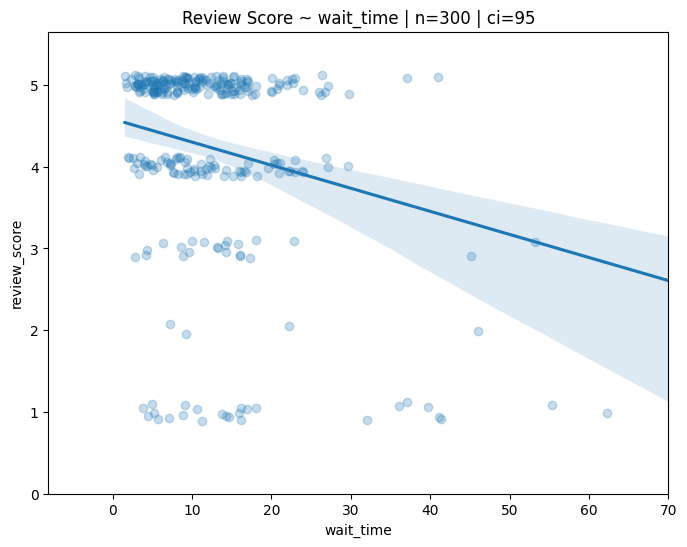

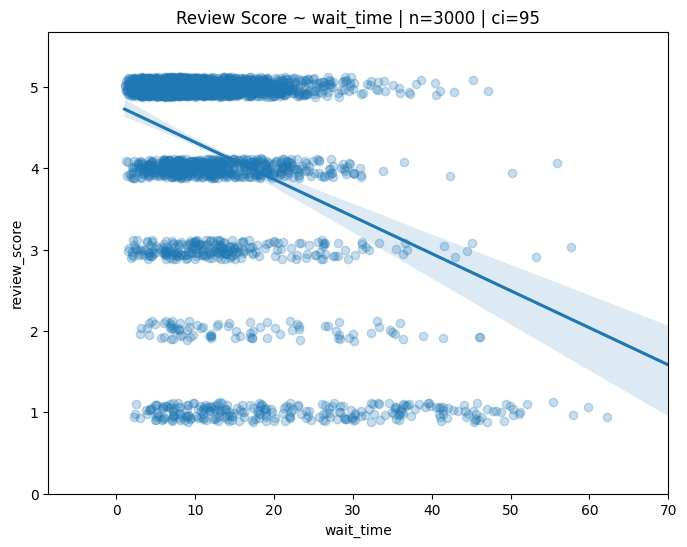

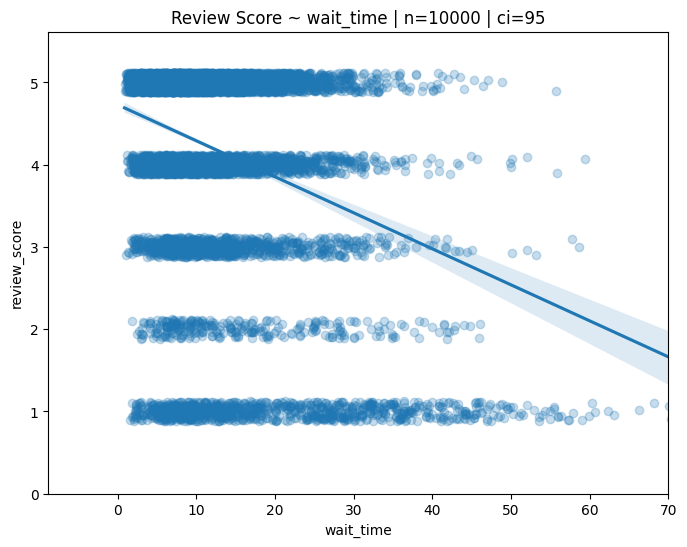

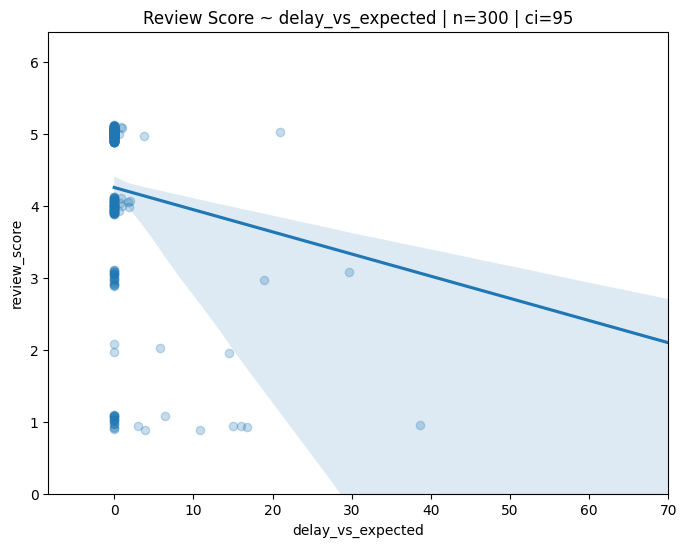

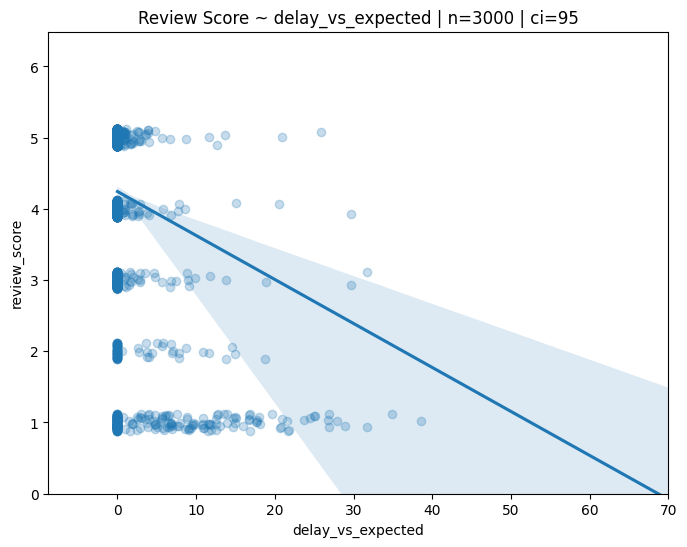

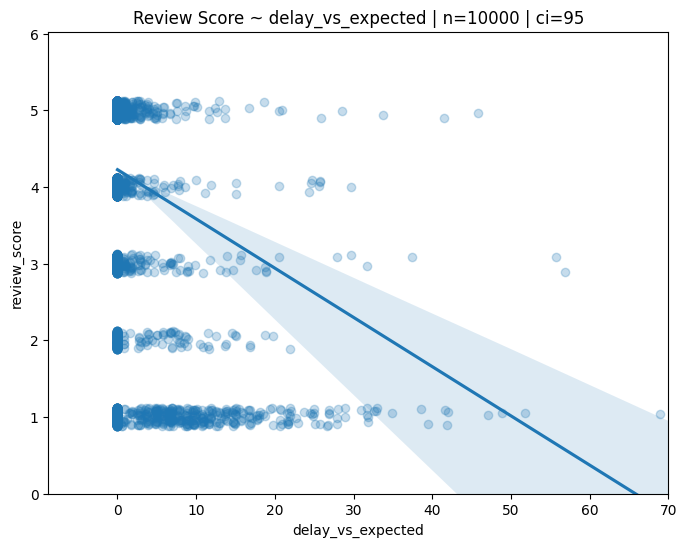

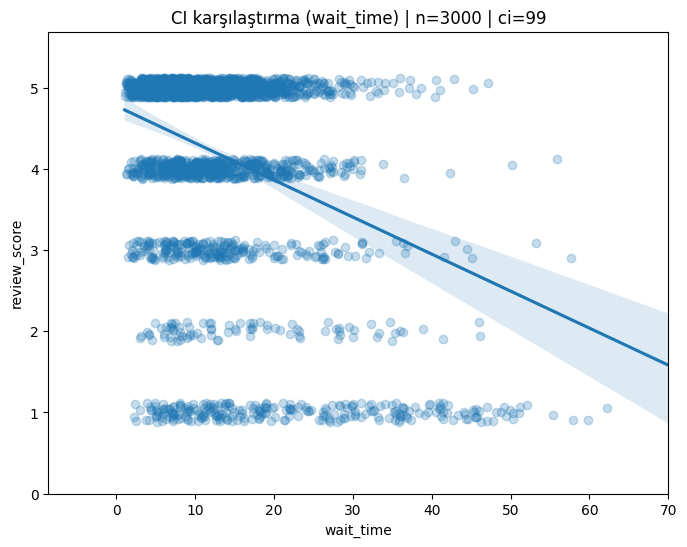

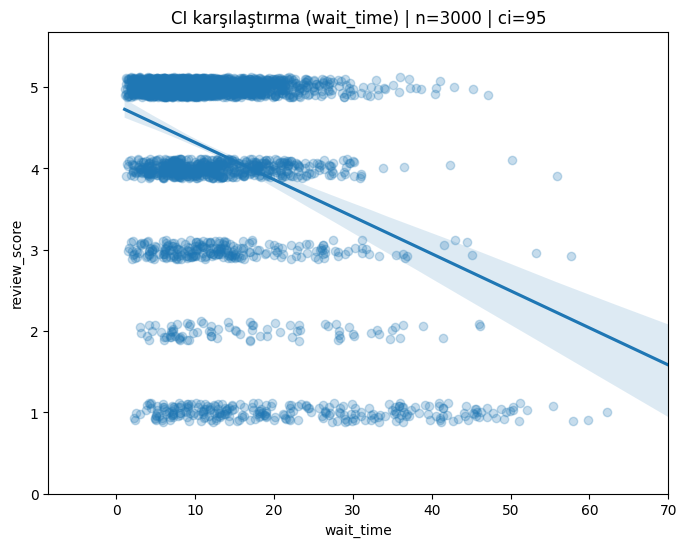

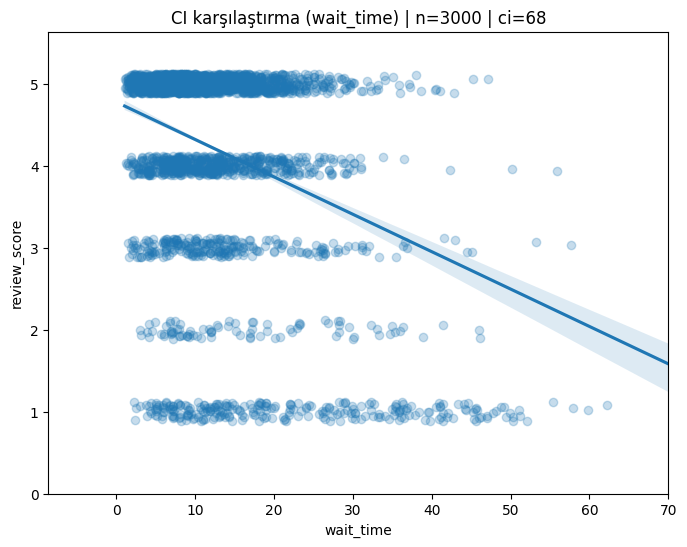

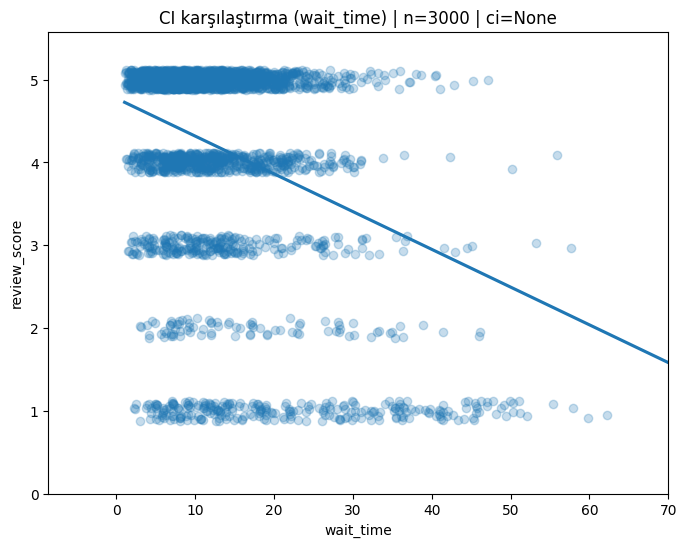

In [9]:
# CI (güven aralığı) etkisini görmek için farklı örneklem boyutlarıyla bakıyorum
# Not: random_state sabit -> her çalıştırmada aynı örnek, kıyas kolay

def plot_reg_with_ci(df, x_col, title, ci_value):
    plt.figure(figsize=(8, 6))
    sns.regplot(
        data=df,
        x=x_col,
        y="review_score",
        y_jitter=0.12,
        scatter_kws={"alpha": 0.25},
        ci=ci_value
    )
    plt.xlim(right=70)
    plt.ylim(bottom=0)
    plt.title(f"{title} | n={len(df)} | ci={ci_value}")
    plt.xlabel(x_col)
    plt.ylabel("review_score")
    plt.show()

# 3 farklı örneklem boyutu
sample_sizes = [300, 3000, 10000]

# 1) wait_time için: küçük -> orta -> büyük örneklemde CI'yi karşılaştır
for n in sample_sizes:
    sample_df = orders.sample(n=n, random_state=42)
    plot_reg_with_ci(sample_df, "wait_time", "Review Score ~ wait_time", ci_value=95)

# 2) delay_vs_expected için: küçük -> orta -> büyük örneklemde CI'yi karşılaştır
for n in sample_sizes:
    sample_df = orders.sample(n=n, random_state=42)
    plot_reg_with_ci(sample_df, "delay_vs_expected", "Review Score ~ delay_vs_expected", ci_value=95)

# 3) ci parametresiyle oynamak: aynı örneklemde CI genişliği nasıl değişiyor?
sample_df = orders.sample(n=3000, random_state=42)

for ci_value in [99, 95, 68, None]:
    plot_reg_with_ci(sample_df, "wait_time", "CI karşılaştırma (wait_time)", ci_value=ci_value)

# Teslimat Süresi ve Müşteri Puanı Analizi

Bu çalışma, Olist sipariş verileri üzerinde teslimat süresi ve gecikmenin müşteri değerlendirme puanları (`review_score`) ile olan ilişkisini incelemeyi amaçlamaktadır. Analiz, korelasyon matrisi ve Seaborn ile oluşturulan doğrusal regresyon görselleştirmeleri üzerinden yürütülmüştür.

---

## 1. Özellikler Arası Korelasyonun İncelenmesi

Aşağıdaki korelasyon matrisi, siparişlere ait sayısal değişkenler arasındaki doğrusal ilişkileri göstermektedir.

### Genel Bulgular

- `review_score`, kendisiyle doğal olarak **%100 korelasyonludur**.
- `dim_is_five_star` ve `dim_is_one_star` değişkenleri, `review_score`’dan türetildiği için **yüksek mutlak korelasyon** göstermektedir. Bu nedenle analitik olarak bağımsız açıklayıcı değişkenler değildir.
- Bu türetilmiş değişkenler dışarıda bırakıldığında, `review_score` ile en güçlü ilişkiye sahip değişkenler şunlardır:
  - **`wait_time`**
  - **`delay_vs_expected`**

Isı haritası, teslimat süresi uzadıkça müşteri puanlarının düşme eğiliminde olduğunu görsel olarak da desteklemektedir.

---

## 2. `review_score` ile `wait_time` Arasındaki Doğrusal Regresyon

Bu bölümde, siparişin satın alınmasından teslim edilmesine kadar geçen süre (`wait_time`) ile müşteri değerlendirme puanı (`review_score`) arasındaki ilişki incelenmiştir.

### Gözlemler

- Regresyon çizgisinin **negatif eğimli** olması, teslimat süresi uzadıkça müşteri memnuniyetinin azaldığını göstermektedir.
- Noktaların yatay bantlar hâlinde kümelenmesi, `review_score` değişkeninin **ayrık (1–5)** bir skala olmasından kaynaklanmaktadır.
- Buna rağmen regresyon çizgisi, genel eğilimi net bir biçimde yakalamaktadır.

### Yorum

Teslimat süresi uzadıkça, müşterilerin verdiği puanların ortalama olarak düştüğü görülmektedir. Bu durum, teslimat hızının müşteri memnuniyeti üzerinde önemli bir rol oynadığını göstermektedir.

---

## 3. `review_score` ile `delay_vs_expected` Arasındaki Doğrusal Regresyon

Bu analizde, siparişin tahmini teslim tarihine göre gecikme süresi (`delay_vs_expected`) ile müşteri puanı arasındaki ilişki ele alınmıştır.

### Gözlemler

- Regresyon eğimi, `wait_time` grafiğine kıyasla **daha dik ve daha negatiftir**.
- Gecikme süresi arttıkça, düşük puanlı değerlendirmelerin yoğunluğu belirgin şekilde artmaktadır.
- Özellikle 1 ve 2 yıldızlı değerlendirmeler, yüksek gecikme değerlerinde daha sık gözlemlenmektedir.

### Yorum

Müşteriler, toplam teslimat süresinden ziyade siparişin **beklenen teslim tarihinden sonra gelmesine** daha hassas tepki vermektedir. Bu da gecikmenin, memnuniyet üzerinde daha güçlü bir etkisi olduğunu göstermektedir.

---

## 4. Örneklem Boyutunun Güven Aralığına Etkisi (`wait_time`)

Farklı örneklem büyüklükleri kullanılarak (`n = 300`, `n = 3000`, `n = 10000`) oluşturulan regresyon grafiklerinde aşağıdaki desenler gözlemlenmiştir:

### Bulgular

- Örneklem boyutu **küçüldükçe**, regresyon çizgisi etrafındaki **%95 güven aralığı genişlemektedir**.
- Örneklem büyüdükçe:
  - Regresyon eğimi daha **istikrarlı** hâle gelmekte,
  - Güven aralığı **daralmakta** ve belirsizlik azalmaktadır.

### Yorum

Bu durum, büyük örneklemlerin parametre tahminlerinde neden daha güvenilir olduğunu açıkça göstermektedir. Küçük örneklemler, eğim tahminlerinde daha yüksek oynaklık yaratmaktadır.

---

## 5. Güven Aralığı (CI) Seviyelerinin Karşılaştırılması

Aynı veri üzerinde farklı güven aralığı seviyeleri kullanılarak (`ci=99`, `ci=95`, `ci=68`, `ci=None`) oluşturulan grafikler karşılaştırılmıştır.

### Karşılaştırmalı Bulgular

- **`ci=99`**: En geniş güven aralığı, en yüksek belirsizlik
- **`ci=95`**: Dengeli ve varsayılan akademik standart
- **`ci=68`**: Daha dar aralık, ancak daha düşük güven
- **`ci=None`**: Belirsizlik görselleştirilmez, yalnızca regresyon eğimi gösterilir

Tüm bu senaryolarda regresyon eğiminin **negatif kalması**, ilişkinin yönünün örneklem boyutu ve güven seviyesi değişse bile tutarlı olduğunu göstermektedir.

---

## 6. İstatistiksel Değerlendirme ve Hipotez Çerçevesi

- **Boş hipotez (H₀):** Teslimat süresi müşteri puanını etkilemez.
- Regresyon çizgileri etrafındaki %95 güven aralıkları, eğim için **0 değerini içermemektedir**.
- Bu durum, gözlemlenen ilişkinin **istatistiksel olarak anlamlı** olduğunu göstermektedir.

Ancak şu uyarı özellikle vurgulanmalıdır:

**Korelasyon, nedensellik anlamına gelmez.**

Teslimat süresi ile müşteri puanı arasındaki ilişki;
- Ürün kategorisi (örneğin ağır veya hacimli ürünler),
- Satıcı lokasyonu,
- Fiyat seviyesi,
- Lojistik altyapı
gibi **karıştırıcı faktörlerden** etkileniyor olabilir.

Bu nedenle, tek değişkenli regresyon sonuçları nedensel çıkarım yapmak için yeterli değildir.

---

## Sonuç

Bu analiz, teslimat performansının müşteri memnuniyeti üzerinde **istatistiksel olarak anlamlı ve negatif yönlü** bir ilişkiye sahip olduğunu ortaya koymaktadır. Özellikle **beklenen teslim tarihinin aşılması**, müşteri puanlarını toplam teslimat süresinden daha güçlü biçimde düşürmektedir.

Elde edilen bulgular, e-ticaret platformları için teslimat güvenilirliğinin, hız kadar — hatta bazı durumlarda daha da fazla — kritik olduğunu göstermektedir.

🔎 Yorumlama:

* **Boş Hipotez** $H_0$ : "bu değişken review skoru etkilemez", yani katsayısı sıfıra eşittir

Tüm veri noktalarımızı çizdiğimizde:
- Eğim için %95 güven aralığı 0 değerini içermez.
    - 👉 `Daha yavaş teslimatların daha zayıf yorumlarla ilişkili olduğundan %95 emin`.
- "Teslimat süresinin review skorları üzerindeki etkisi hemen hemen sıfırdır" boş hipotezi ile ilişkili **`p-değeri`** %5'ten düşüktür
    - 👉 Bu boş hipotezi güvenle reddedebilir ve **`alternatif hipotez`** = `"teslimat süresi review skoru üzerinde etkiye sahiptir"` düşünebiliriz

🔥 Bulguşlarımızın **istatistiksel olarak anlamlı** olduğu söylenir. 

⚠️ Ancak, **korelasyon nedensellik anlamına gelmez**. 

- Belirli ürünlerin teslimatı doğal olarak daha yavaş olabilir (örn. ağır ürünler)
    - Bu ürün kategorileri, teslimat sürelerinin ne kadar uzun olursa olsun, genellikle düşük review_score'a sahip olacaktır. 

👉 **Karıştırıcı faktörleri** tanımlamak çok önemlidir ve basit bir tek değişkenli regresyon ile yapılamaz. 

</details>

---
🏁 Tebrikler! 

🙏 Notebook'unuzu `commit` ve `push` etmeyi unutmayın